In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import requests
import json
import io

### Read data from server

In [2]:
# your access configuration:
config_file = 'access_config.json'

with open(config_file, 'r') as f: config = json.load(f)
addr = config['address']
folder = config['load_folder']

url_crystalball24 = 'http://{0}/{1}/miso_g9_2018_bt.csv'.format(addr, folder)
try:
    print('Downloading data...')
    r = requests.get(url_crystalball24, timeout=20)
    with io.StringIO(r.text) as f:
        bt = pd.read_csv(f)
    print('...done.')
except:
    print('Problem with reading from Crystalball24.com')
    
print(bt.columns.values)

...done.
['date' 'hour' 'node' 'true_dalmp' 'true_spread' 'pred_dalmp' 'pred_rtlmp'
 'probability']


#### Reshape data for convenience

In [3]:
n_nodes = bt.node.nunique()
n_days = int(bt.shape[0] / n_nodes / 24)
print('Nodes:', n_nodes, ', days:', n_days)

dates = bt.date.values.reshape((n_days, 24, n_nodes))
hours = bt.hour.values.reshape((n_days, 24, n_nodes))
node = bt.node.values.reshape((n_days, 24, n_nodes))
true_dalmp = bt.true_dalmp.values.reshape((n_days, 24, n_nodes))
true_spread = bt.true_spread.values.reshape((n_days, 24, n_nodes))
pred_dalmp = bt.pred_dalmp.values.reshape((n_days, 24, n_nodes))
pred_rtlmp = bt.pred_rtlmp.values.reshape((n_days, 24, n_nodes))
probability = bt.probability.values.reshape((n_days, 24, n_nodes))

Nodes: 32 , days: 370


### Inspect one day / one node predictions

<IPython.core.display.Javascript object>


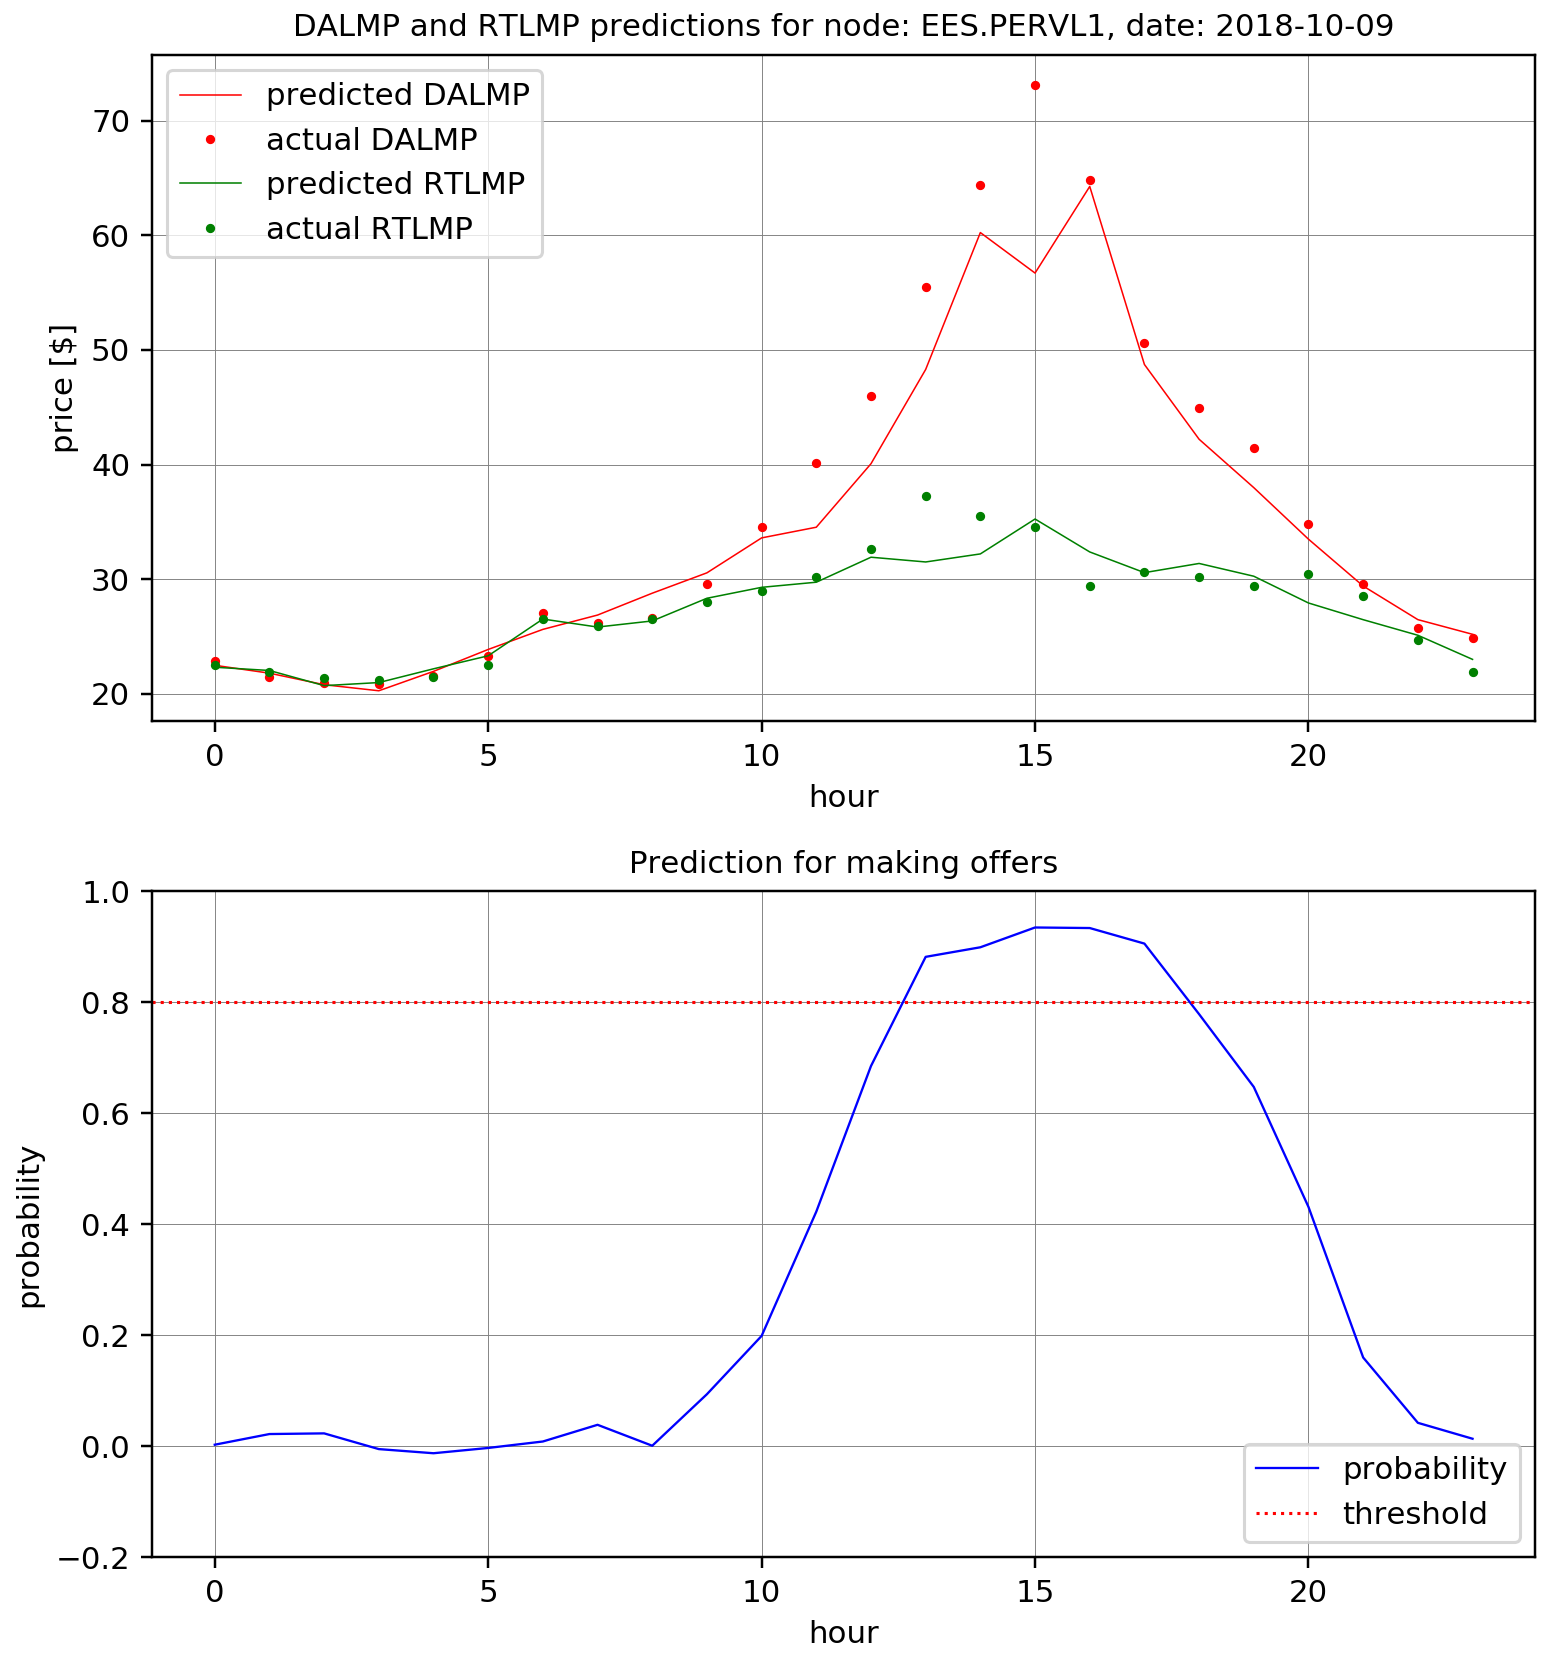

In [4]:
day = n_days-1
n = 0

plt.figure(1, figsize=(7,7.5))

plt.subplot(211)
plt.title('DALMP and RTLMP predictions for node: {0}, date: {1}'.format(node[day,0,n], dates[day,0,n]), fontsize=10)
plt.plot(pred_dalmp[day,:,n], '-', color='red', linewidth=0.5, label='predicted DALMP')
plt.plot(true_dalmp[day,:,n], '.', color='red', markersize=4, label='actual DALMP')
plt.plot(pred_rtlmp[day,:,n], '-', color='green', linewidth=0.5, label='predicted RTLMP')
plt.plot(true_dalmp[day,:,n]+true_spread[day,:,0], '.', color='green', markersize=4, label='actual RTLMP')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('hour')
plt.ylabel('price [$]')
plt.legend(loc='upper left')

thr = 0.8
plt.subplot(212)
plt.title('Prediction for making offers', fontsize=10)
plt.plot(probability[day,:,n], '-', color='blue', linewidth=0.75, label='probability')
plt.axhline(thr, color='red', linestyle='dotted', linewidth=1, label='threshold')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('hour')
plt.ylabel('probability')
plt.ylim(-0.2,1)
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()

### Examine all days / all nodes

<IPython.core.display.Javascript object>


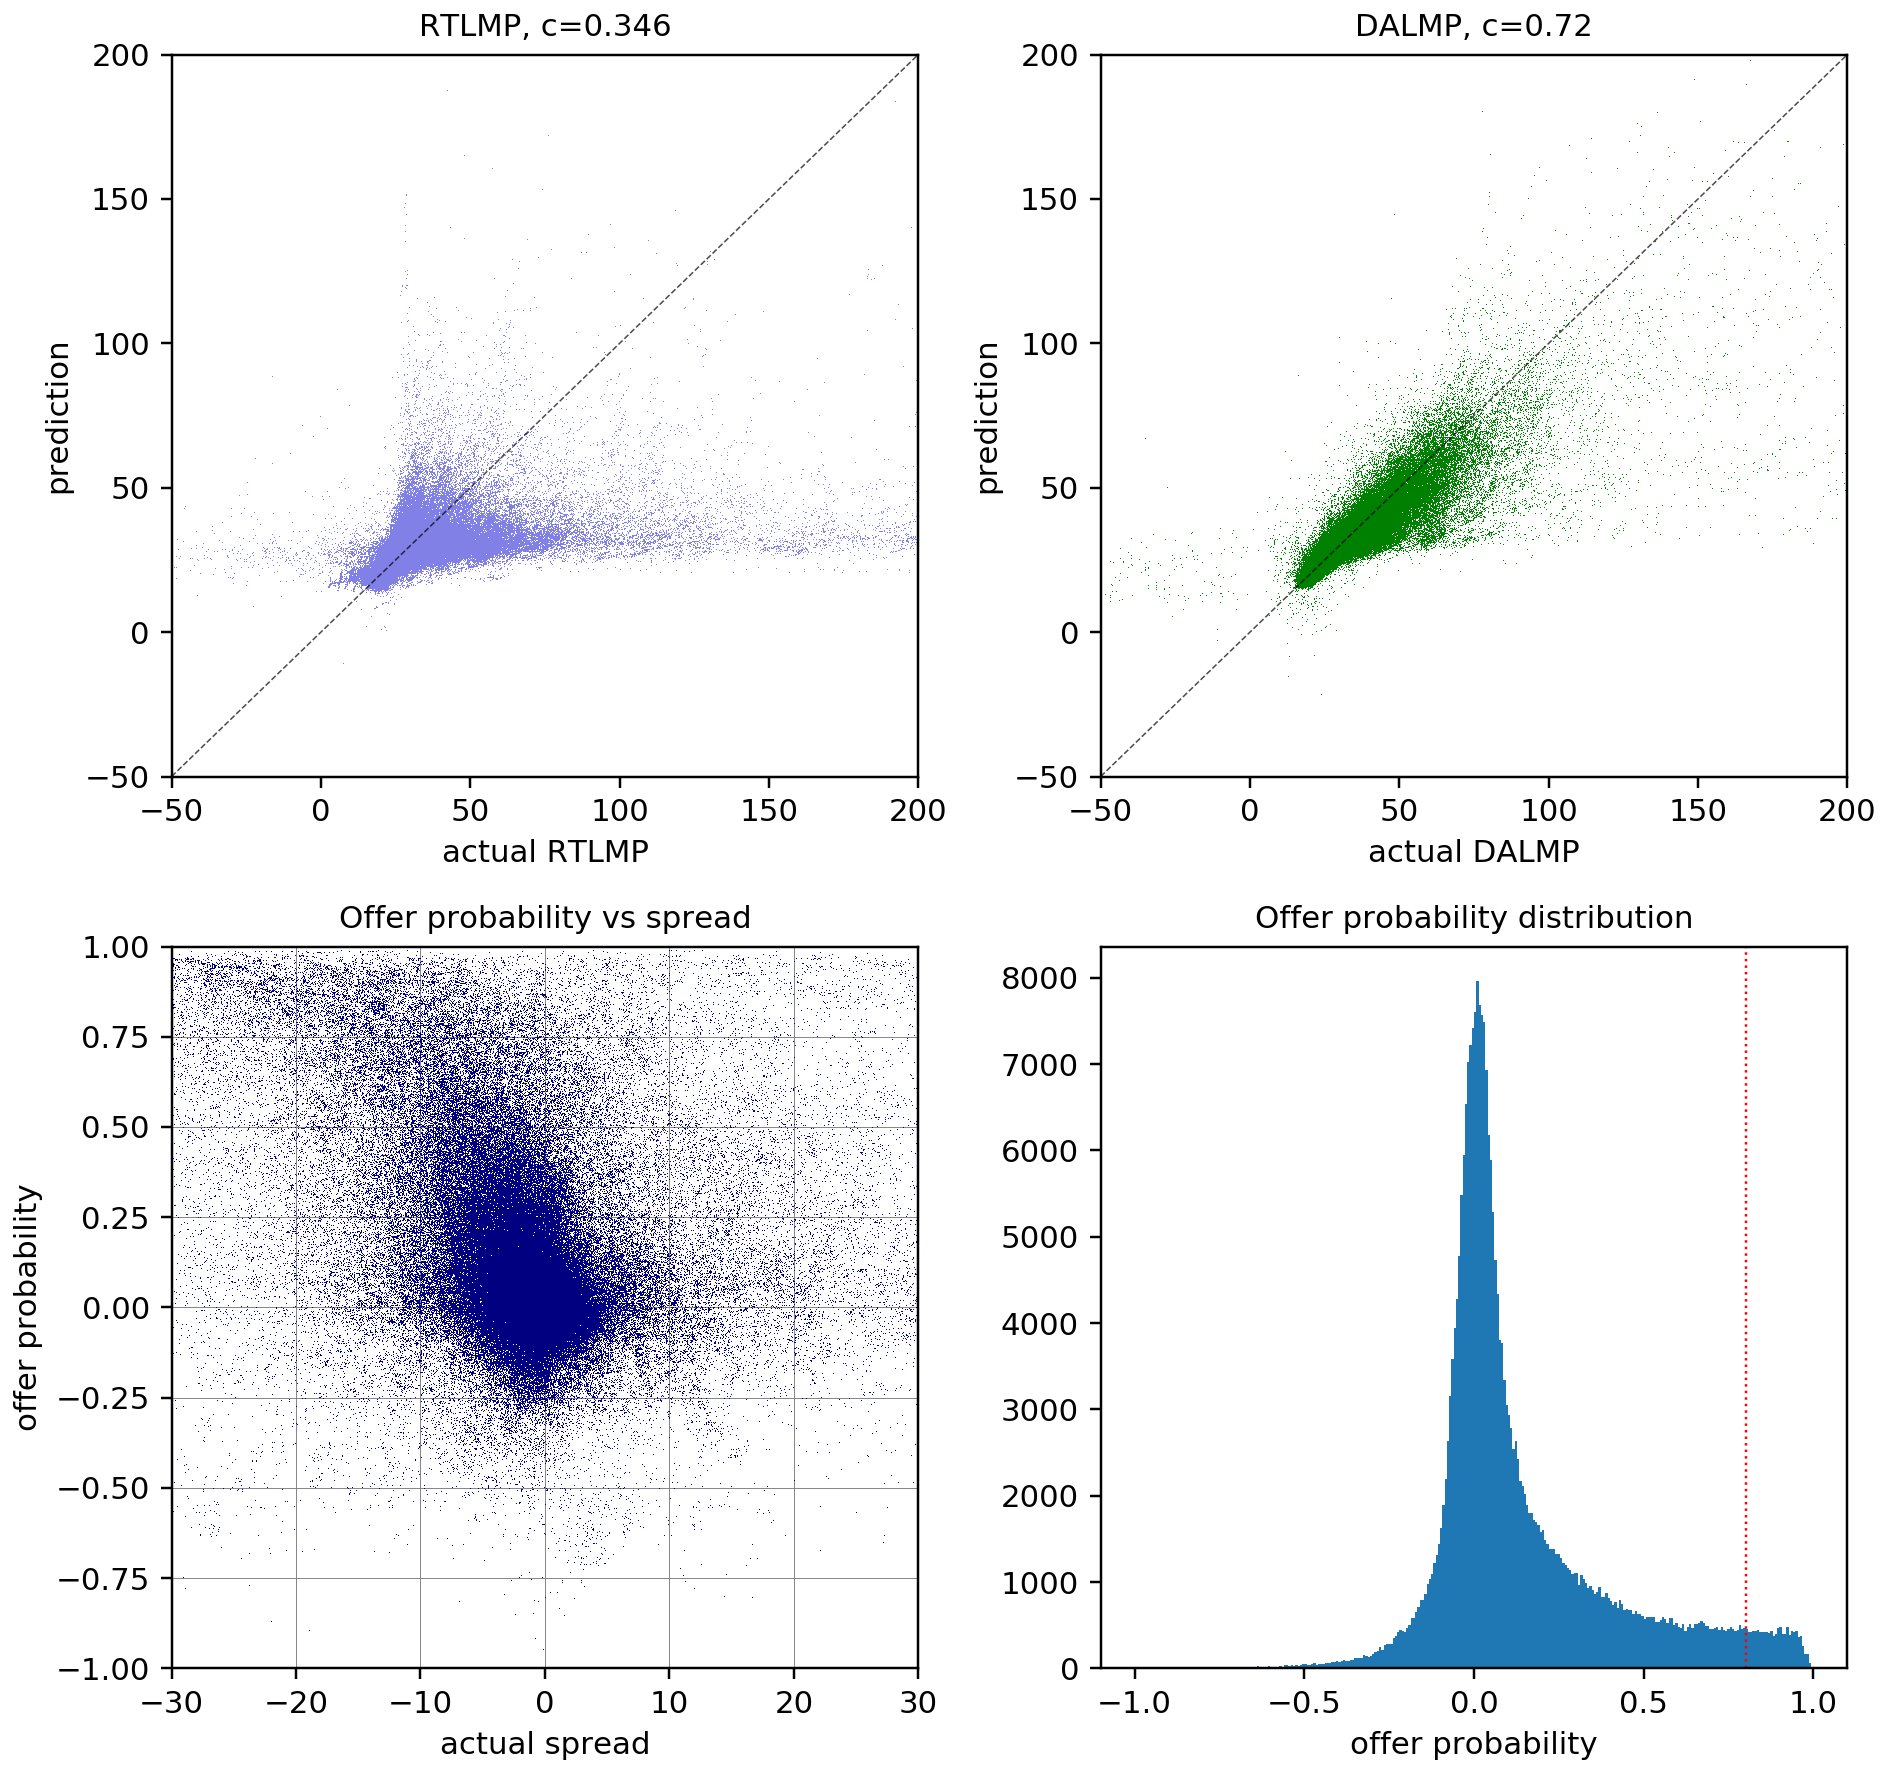

In [5]:
true_rt = bt.true_dalmp.values+bt.true_spread.values
rt_pred_corr = np.corrcoef(true_rt, bt.pred_rtlmp.values)[0,1]
da_pred_corr = np.corrcoef(bt.true_dalmp.values, bt.pred_dalmp.values)[0,1]

thr = 0.8

plt.figure(2, figsize=(8.5,8))
ax = plt.subplot(221)
plt.title('RTLMP, c='+str(np.round(rt_pred_corr, 3)), fontsize=10)
plt.plot(true_rt, bt.pred_rtlmp.values, ',', color=(0.5, 0.5, 0.9))
plt.xlim(-50,200)
plt.ylim(-50,200)
plt.plot(ax.get_xlim(), ax.get_ylim(), color='black', alpha=0.7, linewidth=0.5, ls="--")
plt.xlabel('actual RTLMP')
plt.ylabel('prediction')

ax = plt.subplot(222)
plt.title('DALMP, c='+str(np.round(da_pred_corr, 3)), fontsize=10)
plt.plot(bt.true_dalmp.values, bt.pred_dalmp.values, ',', color=(0, 0.5, 0))
plt.xlim(-50,200)
plt.ylim(-50,200)
plt.plot(ax.get_xlim(), ax.get_ylim(), color='black', alpha=0.7, linewidth=0.5, ls="--")
plt.xlabel('actual DALMP')
plt.ylabel('prediction')

plt.subplot(223)
plt.title('Offer probability vs spread', fontsize=10)
plt.plot(bt.true_spread.values, bt.probability.values, ',', markersize=0.1, color=(0,0,0.5))
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlim(-30,30)
plt.ylim(-1,1)
plt.xlabel('actual spread')
plt.ylabel('offer probability')

plt.subplot(224)
plt.title('Offer probability distribution', fontsize=10)
plt.hist(bt.probability.values, bins=300, range=(-1,1))
plt.axvline(thr, color='red', linestyle='dotted', linewidth=0.8)
plt.xlabel('offer probability')

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()

### Example trading parameters

In [6]:
# Initial capital, let's say $1M:
capital = 1e+6
# Safe, 10% exposure, so target using $100k each day:
exposure = 0.1

daily_volume = exposure * capital
max_virtual = 0.02 * daily_volume
threshold = 0.8
offer_fee = 0.5
price_margin = 2
trade = -1 # offers gain on negative spread (use +1 for bids)

### Run backtest

In [7]:
pnl_daily = np.zeros(n_days, dtype=np.float32)
usd_daily = np.zeros(n_days, dtype=np.float32)
mw_daily = np.zeros(n_days, dtype=np.float32)

print('date\t\t desired\t executed\t total MW\t total $\t PNL\t\t [%]')
for d in range(n_days):
    op_day = dates[d,0,0]
    p = probability[d]
    da = pred_dalmp[d]
    rt = pred_rtlmp[d]
    
    tda = true_dalmp[d]
    tspread = true_spread[d]
    
    # just make offer on every hour/node:
    #go_idx = p > -1
    
    # pre-select hour/node with the confidence prediction
    go_idx = p > threshold
    
    go_count = go_idx.sum()
    if go_count == 0: continue
        
    # price taker: no use of RT prediction:
    #exec_idx = go_idx
        
    # use RT prediction for a simple price managment
    exec_idx = go_idx & (tda > rt + price_margin)
    
    # 0.1MW on each selected hour/node: no use of DA prediction
    #virtual_mw = 0.1 * da[exec_idx]
    
    # keep constant MW **value** each day: use DA prediction for a simple risk managment
    virtual_usd = min(daily_volume / go_count, max_virtual)
    virtual_mw = virtual_usd/da[exec_idx]

    pnl_daily[d] = trade * ((tspread[exec_idx] - offer_fee) * virtual_mw).sum()
    usd_daily[d] = (virtual_mw * tda[exec_idx] + offer_fee).sum()
    mw_daily[d] = (virtual_usd/da[exec_idx]).sum()
    
    print(op_day, '\t', go_count, '\t\t', exec_idx.sum(),
          '\t\t', np.round(mw_daily[d],1), '   \t', np.round(usd_daily[d],1),
          '   \t', np.round(pnl_daily[d],1), '   \t', np.round(100*pnl_daily[d]/capital,2))

date		 desired	 executed	 total MW	 total $	 PNL		 [%]
2017-10-05 	 5 		 5 		 177.7    	 8646.9    	 2096.9    	 0.21
2017-10-08 	 7 		 7 		 290.2    	 18516.3    	 6772.1    	 0.68
2017-10-09 	 57 		 57 		 1261.3    	 78748.5    	 10198.0    	 1.02
2017-10-10 	 19 		 19 		 617.4    	 37891.7    	 16714.9    	 1.67
2017-10-11 	 72 		 67 		 1901.4    	 90619.7    	 15713.7    	 1.57
2017-10-12 	 12 		 12 		 439.5    	 19978.9    	 1368.4    	 0.14
2017-10-14 	 12 		 12 		 367.1    	 24658.9    	 7478.9    	 0.75
2017-10-15 	 85 		 85 		 2054.2    	 97509.2    	 30396.3    	 3.04
2017-10-16 	 134 		 124 		 2415.7    	 83460.5    	 21317.2    	 2.13
2017-10-18 	 10 		 10 		 459.1    	 20937.5    	 5641.2    	 0.56
2017-10-20 	 52 		 52 		 2839.1    	 101638.1    	 36193.3    	 3.62
2017-11-06 	 5 		 5 		 189.7    	 9891.6    	 -19440.8    	 -1.94
2017-11-07 	 30 		 30 		 1165.4    	 54758.1    	 15339.7    	 1.53
2017-11-08 	 38 		 38 		 1789.9    	 76006.9    	 23071.2    	 2.31
2017-11-

<IPython.core.display.Javascript object>


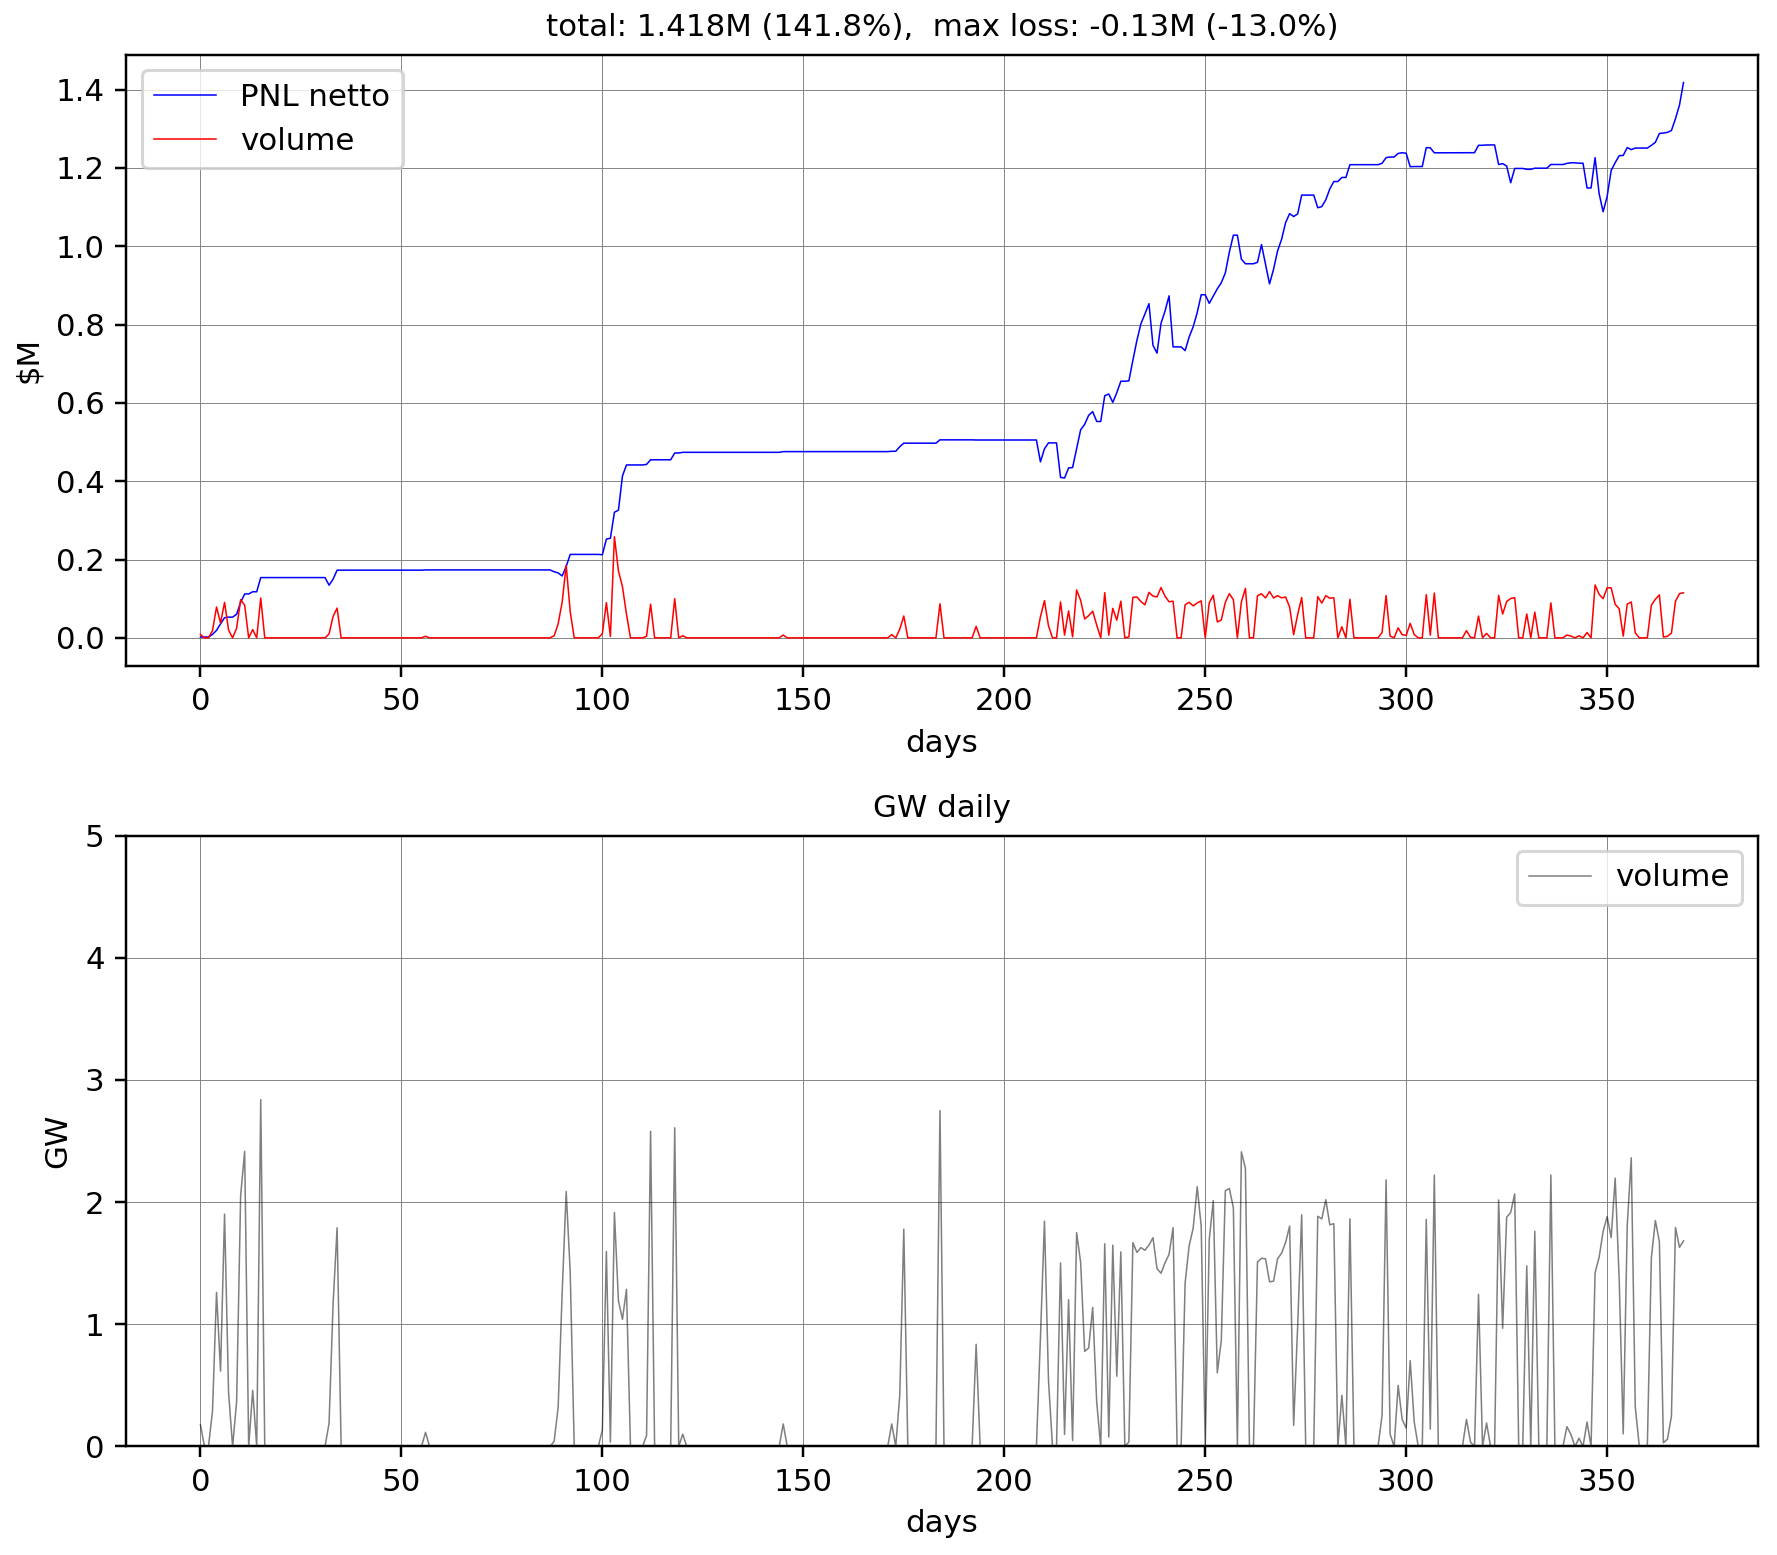

In [8]:
tot_usd = np.round(np.cumsum(pnl_daily)[-1] * 1e-6,3)
tot_pct = np.round(100 * np.cumsum(pnl_daily)[-1] / capital,1)
max_loss_usd = np.round(np.amin(pnl_daily) * 1e-6,3)
max_loss_pct = np.round(100 * np.amin(pnl_daily) / capital,1)

plt.figure(3, figsize=(8,7))

plt.subplot(211)
plt.title('total: {0}M ({1}%),  max loss: {2}M ({3}%)'.format(tot_usd,tot_pct,max_loss_usd,max_loss_pct), fontsize=10)
plt.plot(1e-6 * np.cumsum(pnl_daily), '-', color='blue', linewidth=0.5, label='PNL netto')
plt.plot(1e-6 * usd_daily, '-', color='red', linewidth=0.5, label='volume')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('days')
plt.ylabel('$M')
plt.legend()

plt.subplot(212)
plt.title('GW daily', fontsize=10)
plt.plot(1e-3*mw_daily, '-', color='black', alpha=0.5, linewidth=0.5, label='volume')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('days')
plt.ylabel('GW')
plt.ylim(0,5)
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()